In [1]:
import numpy as np
from PIL import Image, ImageFont, ImageDraw
from PIL.ImageChops import add, subtract, multiply, difference, screen
import PIL.ImageStat as stat
from skimage.io import imread, imsave, imshow, show, imread_collection,imshow_collection
from skimage import color, exposure, img_as_float, data
from skimage.transform import SimilarityTransform, warp, swirl, ProjectiveTransform
from skimage.util import invert, random_noise, montage
import matplotlib.image as mpimg
import matplotlib.pylab as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib.path import Path
from scipy.ndimage import affine_transform, zoom
from scipy import misc

Pha trộn hình ảnh bằng phương pháp Pyramid

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import pyramid_reduce, pyramid_expand, resize

def get_gaussian_pyramid(image, max_levels=6):
    """Tạo Gaussian Pyramid từ ảnh."""
    rows, cols = image.shape[:2]
    gaussian_pyramid = [image]
    while rows > 1 and cols > 1 and len(gaussian_pyramid) < max_levels:
        image = pyramid_reduce(image, downscale=2)
        gaussian_pyramid.append(image)
        rows, cols = image.shape[:2]
    return gaussian_pyramid

def get_laplacian_pyramid(gaussian_pyramid):
    """Tạo Laplacian Pyramid từ Gaussian Pyramid."""
    laplacian_pyramid = []
    for i in range(len(gaussian_pyramid) - 1):
        expanded = resize(pyramid_expand(gaussian_pyramid[i + 1]), gaussian_pyramid[i].shape, anti_aliasing=True)
        laplacian_layer = gaussian_pyramid[i] - expanded
        laplacian_pyramid.append(laplacian_layer)
    laplacian_pyramid.append(gaussian_pyramid[-1])  # Thêm lớp cuối cùng
    return laplacian_pyramid

def reconstruct_image_from_laplacian_pyramid(pyramid):
    """Tái tạo lại ảnh từ Laplacian Pyramid."""
    reconstructed = pyramid[-1]
    for i in range(len(pyramid) - 2, -1, -1):
        expanded = resize(pyramid_expand(reconstructed), pyramid[i].shape, anti_aliasing=True)
        reconstructed = pyramid[i] + expanded
    return np.clip(reconstructed, 0, 1)  # Đảm bảo giá trị nằm trong khoảng [0, 1]

# Đọc và chuẩn hóa ảnh
A = imread('../images/apple.png')[..., :3] / 255.0  # Ảnh A (Apple)
B = imread('../images/orange.png')[..., :3] / 255.0  # Ảnh B (Orange)
M = imread('../images/mask.png')[..., :3] / 255.0  #

Thuật toán Marr and Hildreth's zero-crossing để phát hiện cạnh

C:\Users\PC\AppData\Local\Temp\ipykernel_21156\569138946.py:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread('../images/zebras.jpg')


Max pixel value: 0.9206827450980393


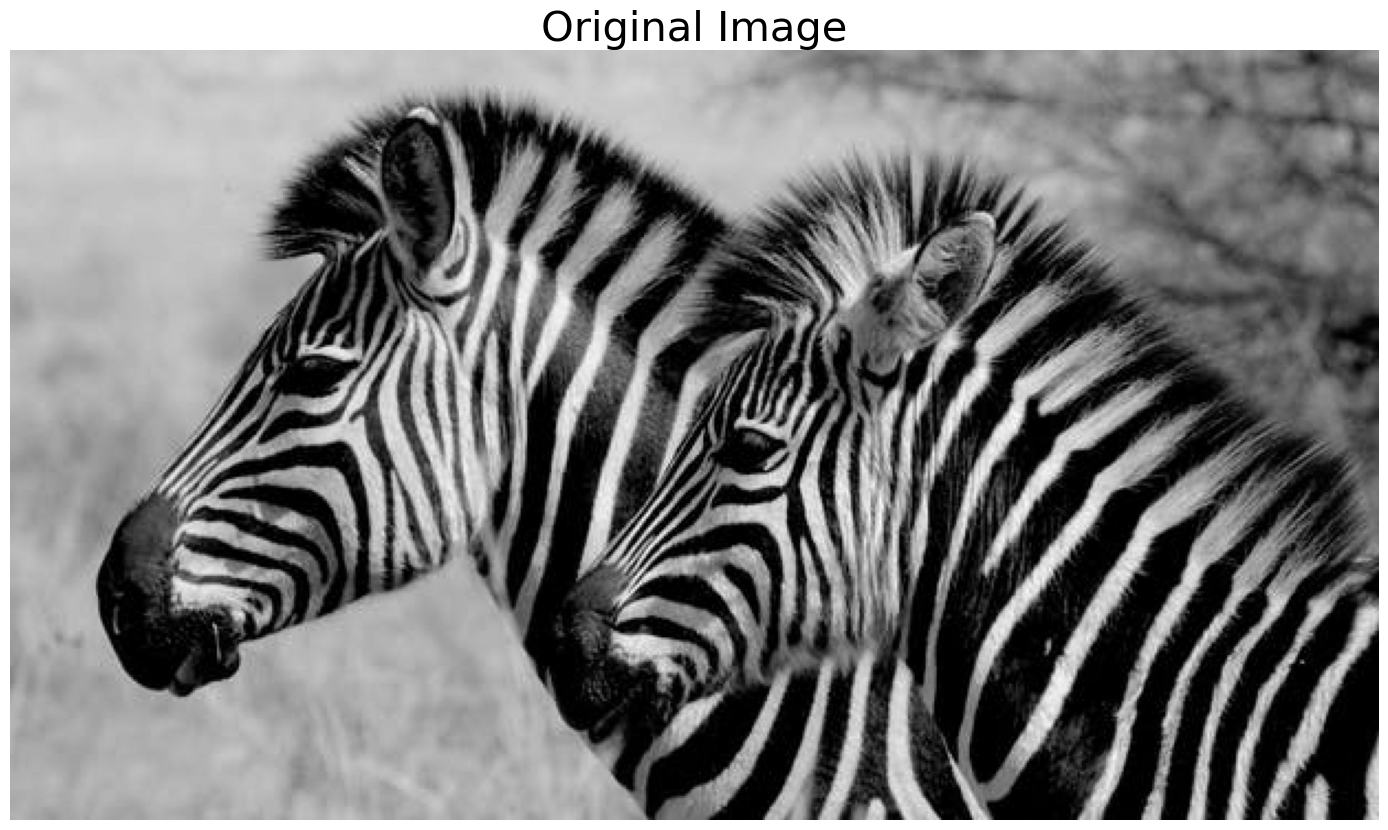

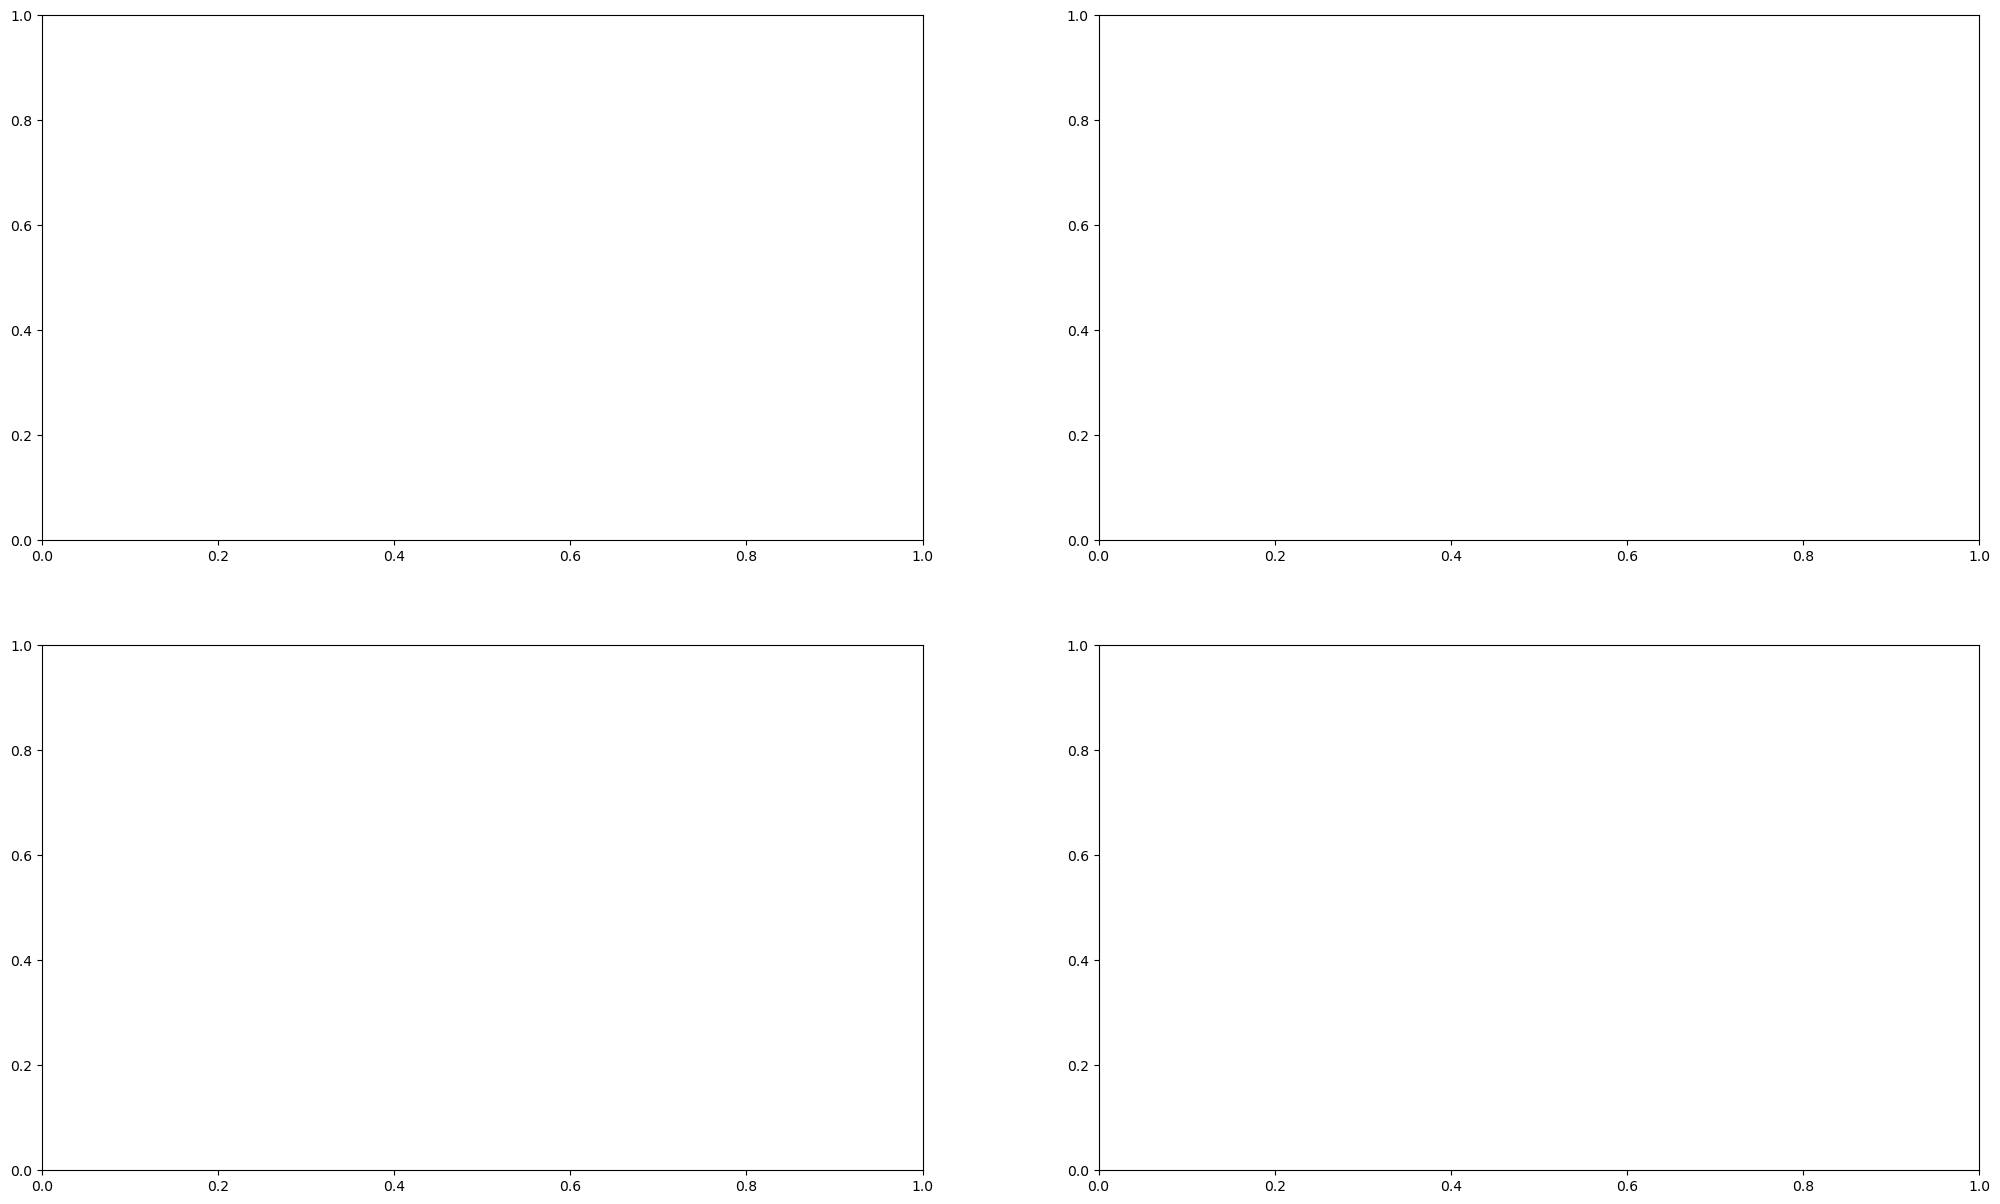

In [8]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
import imageio
def any_neighbor_zero(img, i, j):
  """Kiểm tra xem bất kỳ hàng xóm nào của pixel có giá trị 0 hay không."""
  for k in range(-1, 2):
    for l in range(-1, 2):
      if k == 0 and l == 0:
        continue
      if img[i + k, j + l] == 0:
        return False
  return True
def zero_crossing(img):
  """Áp dụng phương pháp zero-crossing để phát hiện biên."""
  img[img > 0] = 1
  img[img < 0] = 0
  out_img = np.zeros(img.shape)
  for i in range(1, img.shape[0] - 1):
    for j in range(1, img.shape[1] - 1):
      if img[i, j] > 0 and any_neighbor_zero(img, i, j):
        out_img[i, j] = 255
  return out_img
# Đọc ảnh
img = imageio.imread('../images/zebras.jpg')
# Chuyên sang grayscale nếu cần
if len(img.shape) == 3: # Kiểm tra nếu ảnh là RGB
  img = rgb2gray(img)
print("Max pixel value:", np.max(img))
plt.figure(figsize=(20, 10))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Original Image', size=30)
# Áp dụng Gaussian-Laplace và zero-crossing với nhiều sigma
fig = plt.figure(figsize=(25, 15))
plt.gray() # Hiển thị kết quả lọc ở dạng grayscale
for idx, sigma in enumerate(range(2, 10, 2)):
  plt.subplot(2, 2, idx + 1)
  result = ndimage.gaussian_laplace(img, sigma=sigma)
  result = zero_crossing(result)
  plt.imshow

Thuật toán non-max suppression để làm mỏng các cạnh trong hình ảnh có độ lớn gradient.

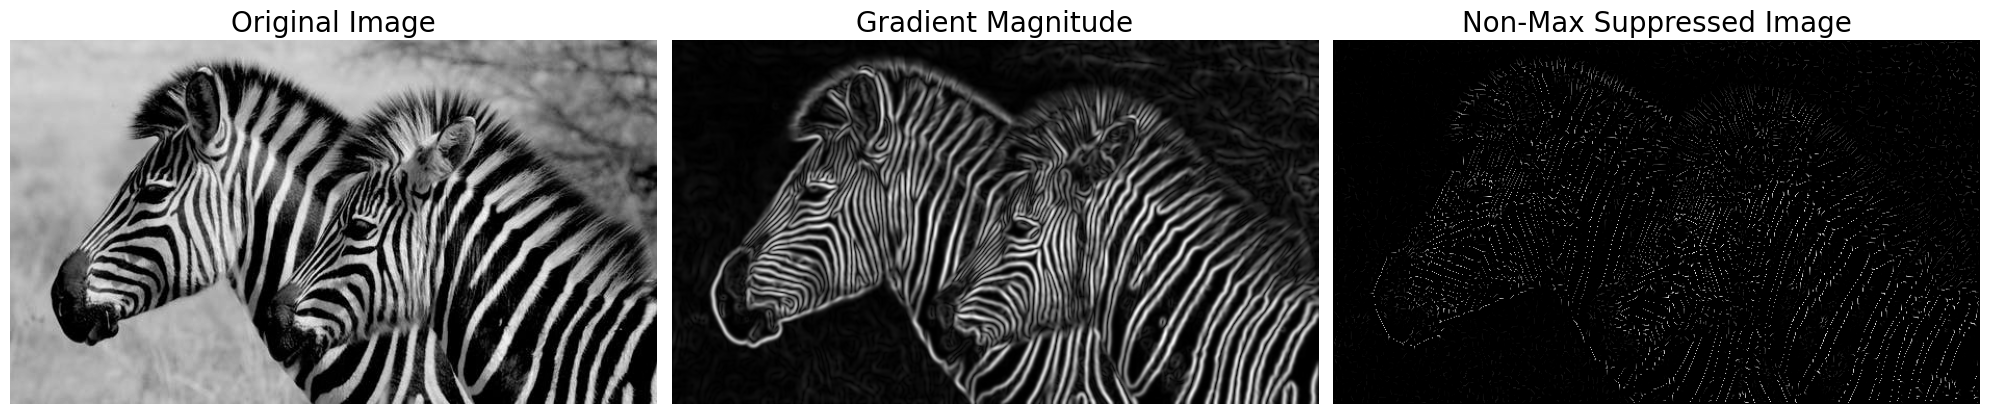

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.color import rgb2gray
from scipy.ndimage import gaussian_filter, sobel

def gradient_intensity_and_orientation(image):
    """Tính gradient cường độ và hướng bằng Sobel."""
    gx = sobel(image, axis=0)  # Gradient theo chiều x
    gy = sobel(image, axis=1)  # Gradient theo chiều y
    magnitude = np.sqrt(gx**2 + gy**2)  # Cường độ gradient
    direction = np.arctan2(gy, gx) * 180 / np.pi  # Hướng gradient (độ)
    direction = (direction + 180) % 180  # Chuyển hướng về khoảng [0, 180]
    return magnitude, direction

def non_max_suppression(magnitude, direction):
    """Triển khai thuật toán Non-Max Suppression."""
    rows, cols = magnitude.shape
    suppressed = np.zeros((rows, cols), dtype=np.float32)
    angle = direction.copy()

    # Phân loại hướng gradient thành 4 hướng chính: 0, 45, 90, 135
    angle[(angle >= 0) & (angle < 22.5)] = 0
    angle[(angle >= 157.5) & (angle <= 180)] = 0
    angle[(angle >= 22.5) & (angle < 67.5)] = 45
    angle[(angle >= 67.5) & (angle < 112.5)] = 90
    angle[(angle >= 112.5) & (angle < 157.5)] = 135

    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            q = r = 255
            if angle[i, j] == 0:
                q = magnitude[i, j + 1]
                r = magnitude[i, j - 1]
            elif angle[i, j] == 45:
                q = magnitude[i + 1, j - 1]
                r = magnitude[i - 1, j + 1]
            elif angle[i, j] == 90:
                q = magnitude[i + 1, j]
                r = magnitude[i - 1, j]
            elif angle[i, j] == 135:
                q = magnitude[i - 1, j - 1]
                r = magnitude[i + 1, j + 1]

            # Chỉ giữ lại giá trị cường độ lớn nhất
            if magnitude[i, j] >= q and magnitude[i, j] >= r:
                suppressed[i, j] = magnitude[i, j]

    return suppressed

# Đọc ảnh đầu vào và chuyển thành ảnh xám
image = imread('../images/zebras.jpg')
if image.ndim == 3:  # Nếu là ảnh RGB
    image = rgb2gray(image)

# Làm mờ ảnh bằng Gaussian để giảm nhiễu
smoothed = gaussian_filter(image, sigma=1.4)

# Tính gradient cường độ và hướng
magnitude, direction = gradient_intensity_and_orientation(smoothed)

# Áp dụng Non-Max Suppression
nms_image = non_max_suppression(magnitude, direction)

# Hiển thị kết quả
plt.figure(figsize=(20, 10))

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image', size=20)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(magnitude, cmap='gray')
plt.title('Gradient Magnitude', size=20)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(nms_image, cmap='gray')
plt.title('Non-Max Suppressed Image', size=20)
plt.axis('off')

plt.tight_layout()
plt.show()
